In [1]:
import warnings
warnings.filterwarnings("ignore")

import os
import time
import json
import numpy as np
import pandas as pd
import geopandas as gpd
import pickle as pkl
import networkx as nx
import matplotlib.pyplot as plt

import src
from src.reload import deep_reload

In [2]:
hour_cost_4h = 2 * 20 
hour_cost_8h = 2 * 20
hour_cost_16h = 2 * 20 + 2 * (2 * 79 + 200) / 16
hour_cost_24h = 2 * 20 + 3 * (2 * 79 + 200) / 24

hour_cost_4h, hour_cost_8h, hour_cost_16h, hour_cost_24h

(40, 40, 84.75, 84.75)

In [3]:
hour_cost_4h = 2 * 20 + (79 + 200) / 4
hour_cost_8h = 2 * 20 + (79 + 200) / 8
hour_cost_16h = 2 * 20 + 2 * (2 * 79 + 200) / 16
hour_cost_24h = 2 * 20 + 3 * (2 * 79 + 200) / 24

hour_cost_4h, hour_cost_8h, hour_cost_16h, hour_cost_24h

(109.75, 74.875, 84.75, 84.75)

In [4]:
riverside_commute = (8 * 20 * 2 + 40) / 3
humboldt_commute = (6 * 20 * 2 + 40) / 3

hour_costs = {
    1000000000: {
        '4 Hour': 2 * 20,
        '8 Hour': 2 * 20,
        '16 Hour': 2 * 20 + 2 * (2 * 79 + 200) / 16,
        '24 Hour': 2 * 20 + 3 * (2 * 79 + 200) / 24,
    },
    2000000000: {
        '4 Hour': 2 * 20 + (79 + 200 + riverside_commute) / 4,
        '8 Hour': 2 * 20 + (79 + 200 + riverside_commute) / 8,
        '16 Hour': 2 * 20 + 2 * (2 * 79 + 200 + riverside_commute) / 16,
        '24 Hour': 2 * 20 + 3 * (2 * 79 + 200 + riverside_commute) / 24,
    },
    3000000000: {
        '4 Hour': 2 * 20 + (79 + 200 + humboldt_commute) / 4,
        '8 Hour': 2 * 20 + (79 + 200 + humboldt_commute) / 8,
        '16 Hour': 2 * 20 + 2 * (2 * 79 + 200 + humboldt_commute) / 16,
        '24 Hour': 2 * 20 + 3 * (2 * 79 + 200 + humboldt_commute) / 24,
    },
}

In [5]:
hour_costs

{1000000000: {'4 Hour': 40, '8 Hour': 40, '16 Hour': 84.75, '24 Hour': 84.75},
 2000000000: {'4 Hour': 139.75,
  '8 Hour': 89.875,
  '16 Hour': 99.75,
  '24 Hour': 99.75},
 3000000000: {'4 Hour': 133.08333333333331,
  '8 Hour': 86.54166666666666,
  '16 Hour': 96.41666666666666,
  '24 Hour': 96.41666666666666}}

In [6]:
fig_path = 'figs/'

In [7]:
total_cost = {
    'Bolt': {},
    'Lightning': {},
    'Ioniq': {},
    'Model 3': {},
}

In [8]:
gdf_zones = gpd.read_file('../charger_network_analysis/Data/NGOD/Shapes/V2_Zones.shp')

gdf_zones['in_california'] = gdf_zones['V2ZONEID'].apply(lambda zid: 'CA' in zid)

gdf_zones_california = gdf_zones[gdf_zones['in_california']]

gdf_zones_california = gdf_zones_california.explode(drop = True)

In [9]:
# Loading Info

graph = src.graph.graph_from_json('graph.json')

In [10]:
routes = json.load(open('Outputs/routes_bolt_50.json', 'rb'))

In [11]:
nodes_visited = np.concatenate([r['nodes'] for r in routes])
plot_sg = src.graph.subgraph(graph, nodes_visited)

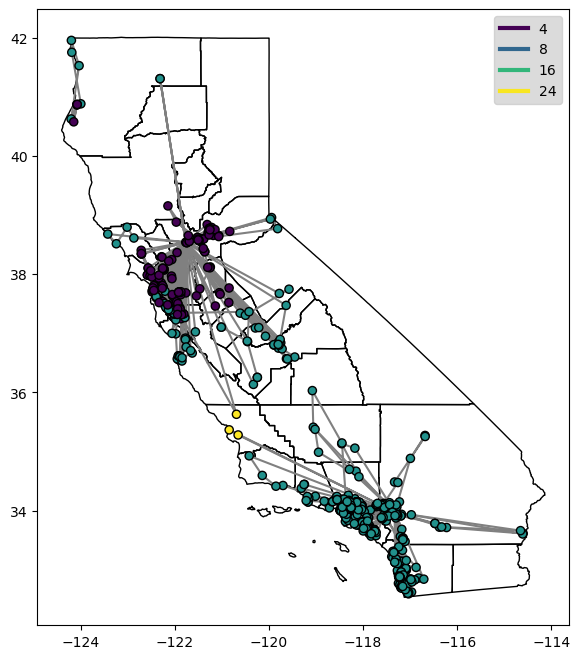

In [12]:
routes = np.random.choice(routes, len(routes), replace = False)

for route in routes:

    route_expected_time = np.array(route['time']).mean()
    
    if route_expected_time <= 4*3600:
        vn = .0

    elif route_expected_time <= 8*3600:
        vn = .33

    elif route_expected_time <= 16*3600:
        vn = .66

    elif route_expected_time <= 24*3600:
        vn = .99
        
    # print(route['vehicle'], vn)
    for n in route['nodes']:
        plot_sg._node[n]['route_vehicle'] = vn

kwargs = {
    'show_links': False,
    'node_field': 'route_vehicle',
    'scatter': {
        's': 35,
        'ec': 'k',
    },
    'line': {
        'color': 'gray',
        'zorder': 0,
    },
}

fig, ax = plt.subplots(figsize = (8, 8))

gdf_zones_california.plot(ax = ax, fc = 'none', ec = 'k', zorder = 0)


src.figures.plot_graph(plot_sg, ax = ax, **kwargs)
src.figures.plot_routes(plot_sg, routes, ax = ax, **kwargs)

from matplotlib.lines import Line2D

colors = src.figures.colormap('viridis')(np.array([0, .33, .66, .99]))
lines = [Line2D([0], [0], color=c, linewidth=3, linestyle='-') for c in colors]
labels = ['4', '8', '16', '24']
ax.legend(lines, labels, facecolor = 'lightgray', markerscale = 40)

fig.savefig(fig_path + 'bolt_50_map.png', bbox_inches = 'tight', dpi = 300)

In [13]:
times = []
time_costs = []
energy_costs = []
total_costs = []

for route in routes:
    
    times.append(route['time'])
    time_costs.append(np.array(route['time']) *
                      hour_costs[route['nodes'][0]][route['type']]/ 3600)
    energy_costs.append(route['price'])
    total_costs.append(time_costs[-1] + energy_costs[-1])

times = np.array(times) / 3600
time_costs = np.array(time_costs)
energy_costs = np.array(energy_costs)
total_costs = np.array(total_costs)

In [14]:
total_cost['Bolt'][50] = total_costs.sum(axis = 0)

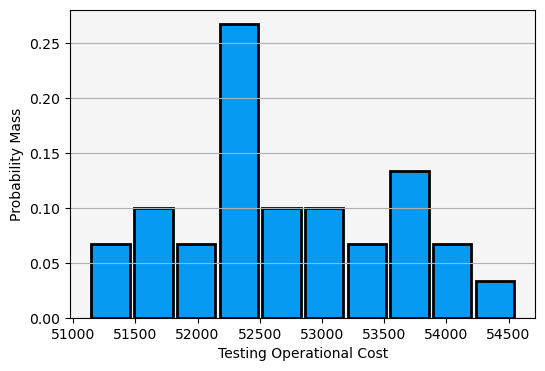

In [15]:
fig, ax = plt.subplots(figsize = (6, 4))



hist, bins = np.histogram(total_costs.sum(axis = 0))

kw = {
    # 'fc': 'lightgray',
    'fc': 'xkcd:azure',
    'ec': 'k',
    'width': (bins[1] - bins[0]) * .9,
    'lw': 2,
}

ax.bar((bins[:-1] + bins[1:]) / 2, hist / sum(hist), **kw)

ax.set(**{
    'xlabel': 'Testing Operational Cost',
    'ylabel': 'Probability Mass',
    'facecolor': 'whitesmoke',
})

ax.grid(axis = 'y')

fig.savefig(fig_path + 'bolt_50_hist.png', bbox_inches = 'tight', dpi = 300)

In [16]:
routes = json.load(open('Outputs/routes_bolt_75.json', 'rb'))

In [17]:
nodes_visited = np.concatenate([r['nodes'] for r in routes])
plot_sg = src.graph.subgraph(graph, nodes_visited)

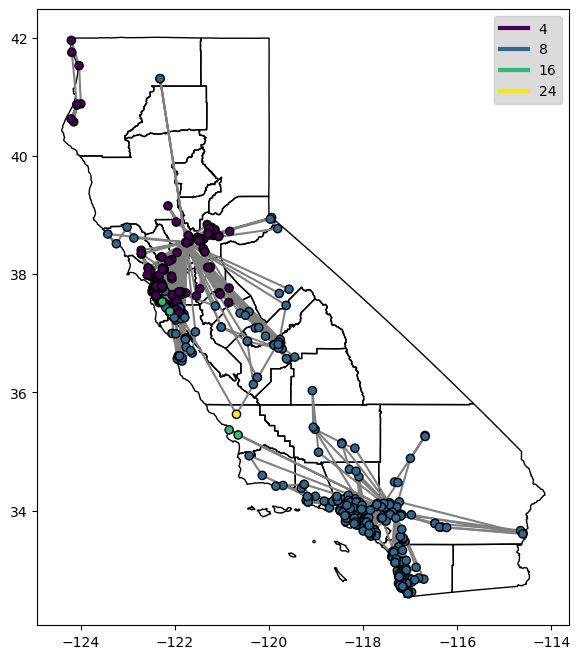

In [18]:
routes = np.random.choice(routes, len(routes), replace = False)

for route in routes:

    route_expected_time = np.array(route['time']).mean()
    
    if route_expected_time <= 4*3600:
        vn = .0

    elif route_expected_time <= 8*3600:
        vn = .33

    elif route_expected_time <= 16*3600:
        vn = .66

    elif route_expected_time <= 24*3600:
        vn = .99
        
    # print(route['vehicle'], vn)
    for n in route['nodes']:
        plot_sg._node[n]['route_vehicle'] = vn

kwargs = {
    'show_links': False,
    'node_field': 'route_vehicle',
    'scatter': {
        's': 35,
        'ec': 'k',
    },
    'line': {
        'color': 'gray',
        'zorder': 0,
    },
}

fig, ax = plt.subplots(figsize = (8, 8))

gdf_zones_california.plot(ax = ax, fc = 'none', ec = 'k', zorder = 0)


src.figures.plot_graph(plot_sg, ax = ax, **kwargs)
src.figures.plot_routes(plot_sg, routes, ax = ax, **kwargs)

from matplotlib.lines import Line2D

colors = src.figures.colormap('viridis')(np.array([0, .33, .66, .99]))
lines = [Line2D([0], [0], color=c, linewidth=3, linestyle='-') for c in colors]
labels = ['4', '8', '16', '24']
ax.legend(lines, labels, facecolor = 'lightgray', markerscale = 40)

fig.savefig(fig_path + 'bolt_75_map.png', bbox_inches = 'tight', dpi = 300)

In [19]:
times = []
time_costs = []
energy_costs = []
total_costs = []

for route in routes:
    
    times.append(route['time'])
    time_costs.append(np.array(route['time']) *
                      hour_costs[route['nodes'][0]][route['type']]/ 3600)
    energy_costs.append(route['price'])
    total_costs.append(time_costs[-1] + energy_costs[-1])

times = np.array(times) / 3600
time_costs = np.array(time_costs)
energy_costs = np.array(energy_costs)
total_costs = np.array(total_costs)

In [20]:
total_cost['Bolt'][75] = total_costs.sum(axis = 0)

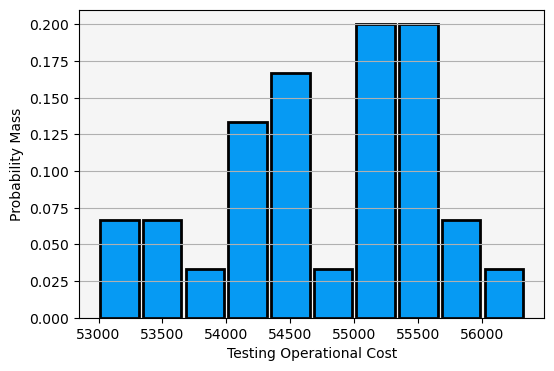

In [21]:
fig, ax = plt.subplots(figsize = (6, 4))



hist, bins = np.histogram(total_costs.sum(axis = 0))

kw = {
    # 'fc': 'lightgray',
    'fc': 'xkcd:azure',
    'ec': 'k',
    'width': (bins[1] - bins[0]) * .9,
    'lw': 2,
}

ax.bar((bins[:-1] + bins[1:]) / 2, hist / sum(hist), **kw)

ax.set(**{
    'xlabel': 'Testing Operational Cost',
    'ylabel': 'Probability Mass',
    'facecolor': 'whitesmoke',
})

ax.grid(axis = 'y')

fig.savefig(fig_path + 'bolt_75_hist.png', bbox_inches = 'tight', dpi = 300)

In [22]:
routes = json.load(open('Outputs/routes_bolt_99.json', 'rb'))

In [23]:
nodes_visited = np.concatenate([r['nodes'] for r in routes])
plot_sg = src.graph.subgraph(graph, nodes_visited)

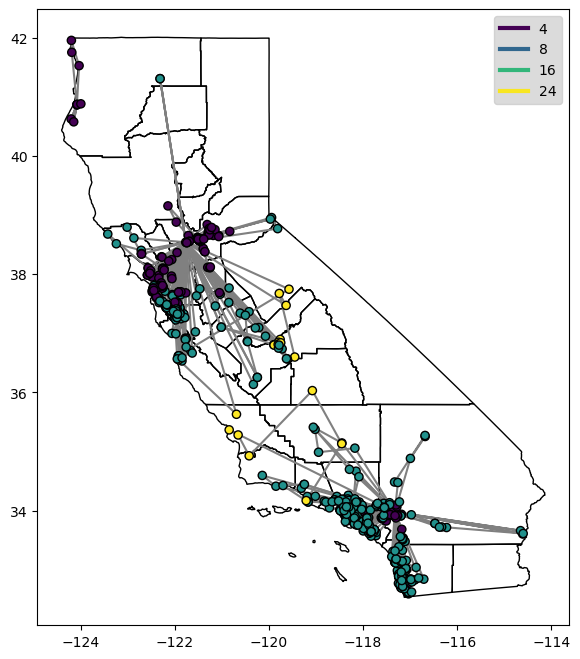

In [24]:
routes = np.random.choice(routes, len(routes), replace = False)

for route in routes:

    route_expected_time = np.array(route['time']).mean()
    
    if route_expected_time <= 4*3600:
        vn = .0

    elif route_expected_time <= 8*3600:
        vn = .33

    elif route_expected_time <= 16*3600:
        vn = .66

    elif route_expected_time <= 24*3600:
        vn = .99
        
    # print(route['vehicle'], vn)
    for n in route['nodes']:
        plot_sg._node[n]['route_vehicle'] = vn

kwargs = {
    'show_links': False,
    'node_field': 'route_vehicle',
    'scatter': {
        's': 35,
        'ec': 'k',
    },
    'line': {
        'color': 'gray',
        'zorder': 0,
    },
}

fig, ax = plt.subplots(figsize = (8, 8))

gdf_zones_california.plot(ax = ax, fc = 'none', ec = 'k', zorder = 0)


src.figures.plot_graph(plot_sg, ax = ax, **kwargs)
src.figures.plot_routes(plot_sg, routes, ax = ax, **kwargs)

from matplotlib.lines import Line2D

colors = src.figures.colormap('viridis')(np.array([0, .33, .66, .99]))
lines = [Line2D([0], [0], color=c, linewidth=3, linestyle='-') for c in colors]
labels = ['4', '8', '16', '24']
ax.legend(lines, labels, facecolor = 'lightgray', markerscale = 40)

fig.savefig(fig_path + 'bolt_99_map.png', bbox_inches = 'tight', dpi = 300)

In [25]:
times = []
time_costs = []
energy_costs = []
total_costs = []

for route in routes:
    
    times.append(route['time'])
    time_costs.append(np.array(route['time']) *
                      hour_costs[route['nodes'][0]][route['type']]/ 3600)
    energy_costs.append(route['price'])
    total_costs.append(time_costs[-1] + energy_costs[-1])

times = np.array(times) / 3600
time_costs = np.array(time_costs)
energy_costs = np.array(energy_costs)
total_costs = np.array(total_costs)

In [26]:
total_cost['Bolt'][99] = total_costs.sum(axis = 0)

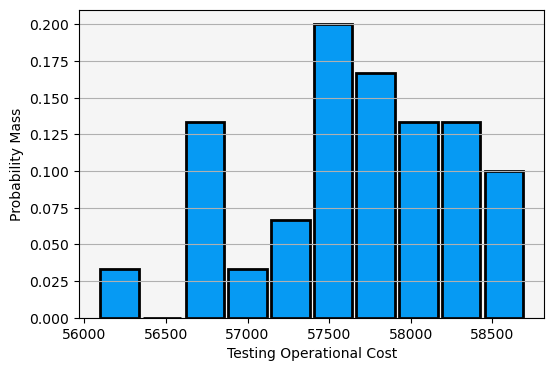

In [27]:
fig, ax = plt.subplots(figsize = (6, 4))

hist, bins = np.histogram(total_costs.sum(axis = 0))

kw = {
    # 'fc': 'lightgray',
    'fc': 'xkcd:azure',
    'ec': 'k',
    'width': (bins[1] - bins[0]) * .9,
    'lw': 2,
}

ax.bar((bins[:-1] + bins[1:]) / 2, hist / sum(hist), **kw)

ax.set(**{
    'xlabel': 'Testing Operational Cost',
    'ylabel': 'Probability Mass',
    'facecolor': 'whitesmoke',
})

ax.grid(axis = 'y')

fig.savefig(fig_path + 'bolt_99_hist.png', bbox_inches = 'tight', dpi = 300)

In [28]:
routes = json.load(open('Outputs/routes_lightning_50.json', 'rb'))

In [29]:
nodes_visited = np.concatenate([r['nodes'] for r in routes])
plot_sg = src.graph.subgraph(graph, nodes_visited)

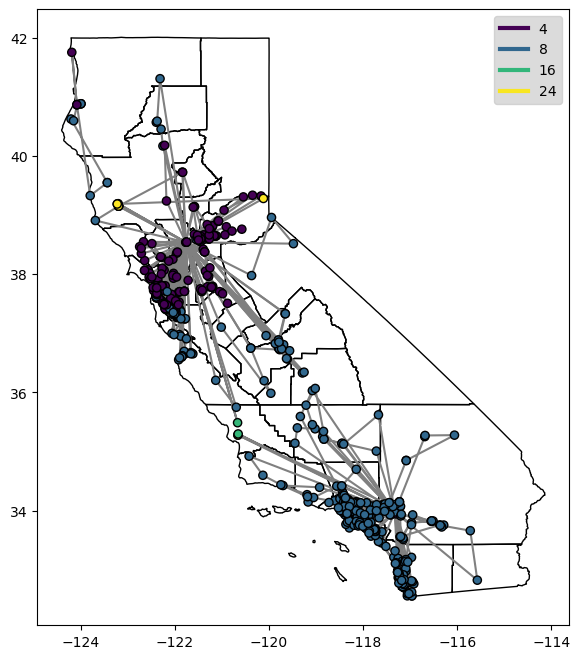

In [30]:
routes = np.random.choice(routes, len(routes), replace = False)

for route in routes:

    route_expected_time = np.array(route['time']).mean()
    
    if route_expected_time <= 4*3600:
        vn = .0

    elif route_expected_time <= 8*3600:
        vn = .33

    elif route_expected_time <= 16*3600:
        vn = .66

    elif route_expected_time <= 24*3600:
        vn = .99
        
    # print(route['vehicle'], vn)
    for n in route['nodes']:
        plot_sg._node[n]['route_vehicle'] = vn

kwargs = {
    'show_links': False,
    'node_field': 'route_vehicle',
    'scatter': {
        's': 35,
        'ec': 'k',
    },
    'line': {
        'color': 'gray',
        'zorder': 0,
    },
}

fig, ax = plt.subplots(figsize = (8, 8))

gdf_zones_california.plot(ax = ax, fc = 'none', ec = 'k', zorder = 0)


src.figures.plot_graph(plot_sg, ax = ax, **kwargs)
src.figures.plot_routes(plot_sg, routes, ax = ax, **kwargs)

from matplotlib.lines import Line2D

colors = src.figures.colormap('viridis')(np.array([0, .33, .66, .99]))
lines = [Line2D([0], [0], color=c, linewidth=3, linestyle='-') for c in colors]
labels = ['4', '8', '16', '24']
ax.legend(lines, labels, facecolor = 'lightgray', markerscale = 40)

fig.savefig(fig_path + 'lightning_50_map.png', bbox_inches = 'tight', dpi = 300)

In [31]:
times = []
time_costs = []
energy_costs = []
total_costs = []

for route in routes:
    
    times.append(route['time'])
    time_costs.append(np.array(route['time']) *
                      hour_costs[route['nodes'][0]][route['type']]/ 3600)
    energy_costs.append(route['price'])
    total_costs.append(time_costs[-1] + energy_costs[-1])

times = np.array(times) / 3600
time_costs = np.array(time_costs)
energy_costs = np.array(energy_costs)
total_costs = np.array(total_costs)

In [32]:
total_cost['Lightning'][50] = total_costs.sum(axis = 0)

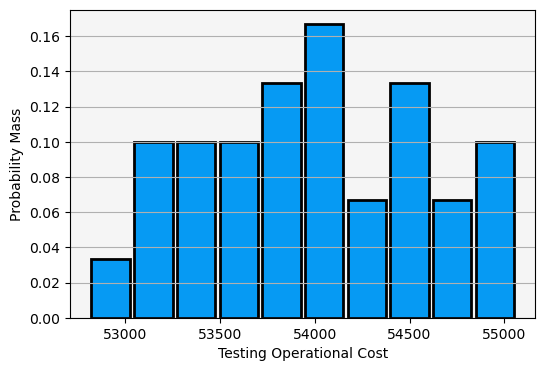

In [33]:
fig, ax = plt.subplots(figsize = (6, 4))

hist, bins = np.histogram(total_costs.sum(axis = 0))

kw = {
    # 'fc': 'lightgray',
    'fc': 'xkcd:azure',
    'ec': 'k',
    'width': (bins[1] - bins[0]) * .9,
    'lw': 2,
}

ax.bar((bins[:-1] + bins[1:]) / 2, hist / sum(hist), **kw)

ax.set(**{
    'xlabel': 'Testing Operational Cost',
    'ylabel': 'Probability Mass',
    'facecolor': 'whitesmoke',
})

ax.grid(axis = 'y')

fig.savefig(fig_path + 'lightning_50_hist.png', bbox_inches = 'tight', dpi = 300)

In [34]:
routes = json.load(open('Outputs/routes_lightning_75.json', 'rb'))

In [35]:
nodes_visited = np.concatenate([r['nodes'] for r in routes])
plot_sg = src.graph.subgraph(graph, nodes_visited)

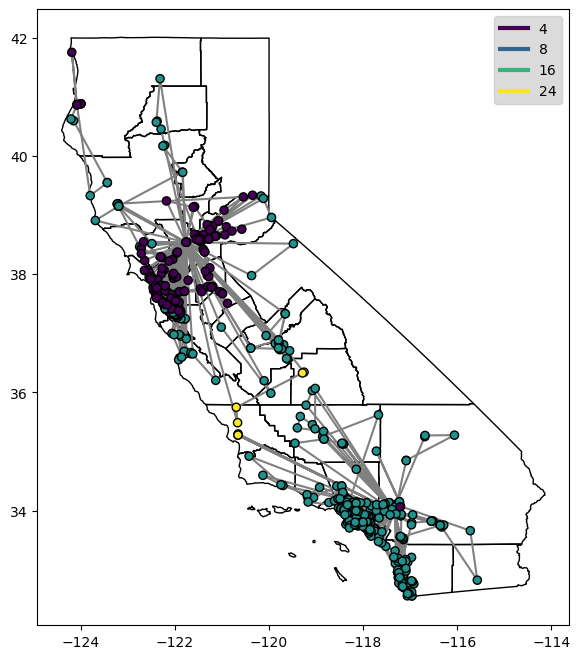

In [36]:
routes = np.random.choice(routes, len(routes), replace = False)

for route in routes:

    route_expected_time = np.array(route['time']).mean()
    
    if route_expected_time <= 4*3600:
        vn = .0

    elif route_expected_time <= 8*3600:
        vn = .33

    elif route_expected_time <= 16*3600:
        vn = .66

    elif route_expected_time <= 24*3600:
        vn = .99
        
    # print(route['vehicle'], vn)
    for n in route['nodes']:
        plot_sg._node[n]['route_vehicle'] = vn

kwargs = {
    'show_links': False,
    'node_field': 'route_vehicle',
    'scatter': {
        's': 35,
        'ec': 'k',
    },
    'line': {
        'color': 'gray',
        'zorder': 0,
    },
}

fig, ax = plt.subplots(figsize = (8, 8))

gdf_zones_california.plot(ax = ax, fc = 'none', ec = 'k', zorder = 0)


src.figures.plot_graph(plot_sg, ax = ax, **kwargs)
src.figures.plot_routes(plot_sg, routes, ax = ax, **kwargs)

from matplotlib.lines import Line2D

colors = src.figures.colormap('viridis')(np.array([0, .33, .66, .99]))
lines = [Line2D([0], [0], color=c, linewidth=3, linestyle='-') for c in colors]
labels = ['4', '8', '16', '24']
ax.legend(lines, labels, facecolor = 'lightgray', markerscale = 40)

fig.savefig(fig_path + 'lightning_75_map.png', bbox_inches = 'tight', dpi = 300)

In [37]:
times = []
time_costs = []
energy_costs = []
total_costs = []

for route in routes:
    
    times.append(route['time'])
    time_costs.append(np.array(route['time']) *
                      hour_costs[route['nodes'][0]][route['type']]/ 3600)
    energy_costs.append(route['price'])
    total_costs.append(time_costs[-1] + energy_costs[-1])

times = np.array(times) / 3600
time_costs = np.array(time_costs)
energy_costs = np.array(energy_costs)
total_costs = np.array(total_costs)

In [38]:
total_cost['Lightning'][75] = total_costs.sum(axis = 0)

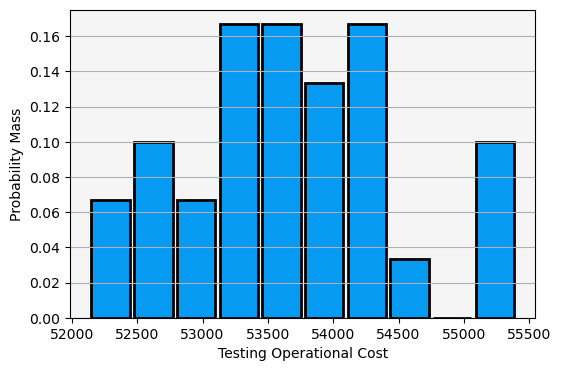

In [39]:
fig, ax = plt.subplots(figsize = (6, 4))

hist, bins = np.histogram(total_costs.sum(axis = 0))

kw = {
    # 'fc': 'lightgray',
    'fc': 'xkcd:azure',
    'ec': 'k',
    'width': (bins[1] - bins[0]) * .9,
    'lw': 2,
}

ax.bar((bins[:-1] + bins[1:]) / 2, hist / sum(hist), **kw)

ax.set(**{
    'xlabel': 'Testing Operational Cost',
    'ylabel': 'Probability Mass',
    'facecolor': 'whitesmoke',
})

ax.grid(axis = 'y')

fig.savefig(fig_path + 'lightning_75_hist.png', bbox_inches = 'tight', dpi = 300)

In [40]:
routes = json.load(open('Outputs/routes_lightning_99.json', 'rb'))

In [41]:
nodes_visited = np.concatenate([r['nodes'] for r in routes])
plot_sg = src.graph.subgraph(graph, nodes_visited)

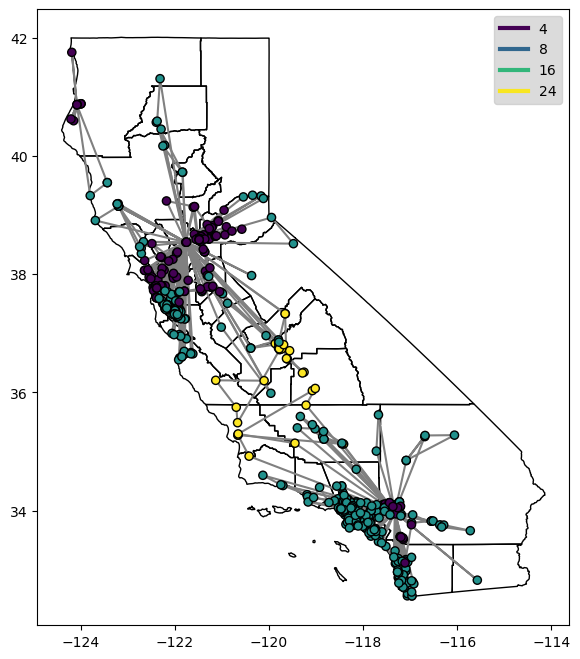

In [42]:
routes = np.random.choice(routes, len(routes), replace = False)

for route in routes:

    route_expected_time = np.array(route['time']).mean()
    
    if route_expected_time <= 4*3600:
        vn = .0

    elif route_expected_time <= 8*3600:
        vn = .33

    elif route_expected_time <= 16*3600:
        vn = .66

    elif route_expected_time <= 24*3600:
        vn = .99
        
    # print(route['vehicle'], vn)
    for n in route['nodes']:
        plot_sg._node[n]['route_vehicle'] = vn

kwargs = {
    'show_links': False,
    'node_field': 'route_vehicle',
    'scatter': {
        's': 35,
        'ec': 'k',
    },
    'line': {
        'color': 'gray',
        'zorder': 0,
    },
}

fig, ax = plt.subplots(figsize = (8, 8))

gdf_zones_california.plot(ax = ax, fc = 'none', ec = 'k', zorder = 0)


src.figures.plot_graph(plot_sg, ax = ax, **kwargs)
src.figures.plot_routes(plot_sg, routes, ax = ax, **kwargs)

from matplotlib.lines import Line2D

colors = src.figures.colormap('viridis')(np.array([0, .33, .66, .99]))
lines = [Line2D([0], [0], color=c, linewidth=3, linestyle='-') for c in colors]
labels = ['4', '8', '16', '24']
ax.legend(lines, labels, facecolor = 'lightgray', markerscale = 40)

fig.savefig(fig_path + 'lightning_99_map.png', bbox_inches = 'tight', dpi = 300)

In [43]:
times = []
time_costs = []
energy_costs = []
total_costs = []

for route in routes:
    
    times.append(route['time'])
    time_costs.append(np.array(route['time']) *
                      hour_costs[route['nodes'][0]][route['type']]/ 3600)
    energy_costs.append(route['price'])
    total_costs.append(time_costs[-1] + energy_costs[-1])

times = np.array(times) / 3600
time_costs = np.array(time_costs)
energy_costs = np.array(energy_costs)
total_costs = np.array(total_costs)

In [44]:
total_cost['Lightning'][99] = total_costs.sum(axis = 0)

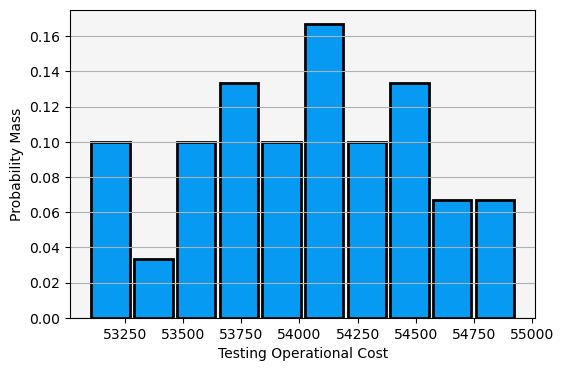

In [45]:
fig, ax = plt.subplots(figsize = (6, 4))

hist, bins = np.histogram(total_costs.sum(axis = 0))

kw = {
    # 'fc': 'lightgray',
    'fc': 'xkcd:azure',
    'ec': 'k',
    'width': (bins[1] - bins[0]) * .9,
    'lw': 2,
}

ax.bar((bins[:-1] + bins[1:]) / 2, hist / sum(hist), **kw)

ax.set(**{
    'xlabel': 'Testing Operational Cost',
    'ylabel': 'Probability Mass',
    'facecolor': 'whitesmoke',
})

ax.grid(axis = 'y')

fig.savefig(fig_path + 'lightning_99_hist.png', bbox_inches = 'tight', dpi = 300)

In [46]:
routes = json.load(open('Outputs/routes_ioniq_50.json', 'rb'))

In [47]:
nodes_visited = np.concatenate([r['nodes'] for r in routes])
plot_sg = src.graph.subgraph(graph, nodes_visited)

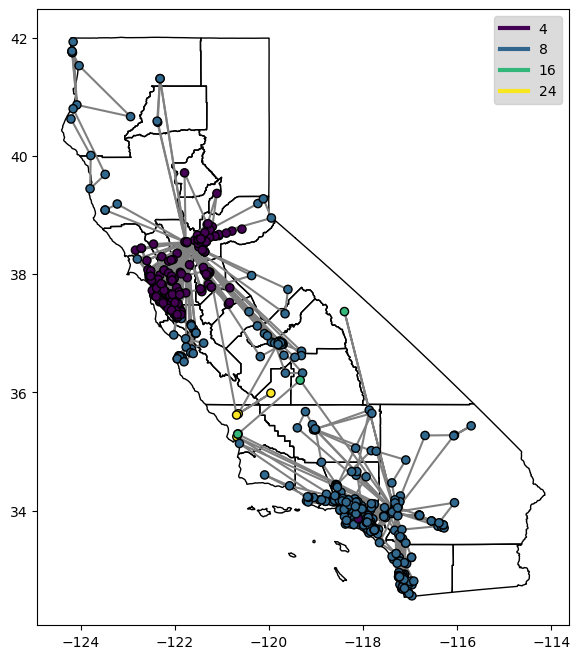

In [48]:
routes = np.random.choice(routes, len(routes), replace = False)

for route in routes:

    route_expected_time = np.array(route['time']).mean()
    
    if route_expected_time <= 4*3600:
        vn = .0

    elif route_expected_time <= 8*3600:
        vn = .33

    elif route_expected_time <= 16*3600:
        vn = .66

    elif route_expected_time <= 24*3600:
        vn = .99
        
    # print(route['vehicle'], vn)
    for n in route['nodes']:
        plot_sg._node[n]['route_vehicle'] = vn

kwargs = {
    'show_links': False,
    'node_field': 'route_vehicle',
    'scatter': {
        's': 35,
        'ec': 'k',
    },
    'line': {
        'color': 'gray',
        'zorder': 0,
    },
}

fig, ax = plt.subplots(figsize = (8, 8))

gdf_zones_california.plot(ax = ax, fc = 'none', ec = 'k', zorder = 0)


src.figures.plot_graph(plot_sg, ax = ax, **kwargs)
src.figures.plot_routes(plot_sg, routes, ax = ax, **kwargs)

from matplotlib.lines import Line2D

colors = src.figures.colormap('viridis')(np.array([0, .33, .66, .99]))
lines = [Line2D([0], [0], color=c, linewidth=3, linestyle='-') for c in colors]
labels = ['4', '8', '16', '24']
ax.legend(lines, labels, facecolor = 'lightgray', markerscale = 40)

fig.savefig(fig_path + 'ioniq_50_map.png', bbox_inches = 'tight', dpi = 300)

In [49]:
times = []
time_costs = []
energy_costs = []
total_costs = []

for route in routes:
    
    times.append(route['time'])
    time_costs.append(np.array(route['time']) *
                      hour_costs[route['nodes'][0]][route['type']]/ 3600)
    energy_costs.append(route['price'])
    total_costs.append(time_costs[-1] + energy_costs[-1])

times = np.array(times) / 3600
time_costs = np.array(time_costs)
energy_costs = np.array(energy_costs)
total_costs = np.array(total_costs)

In [50]:
total_cost['Ioniq'][50] = total_costs.sum(axis = 0)

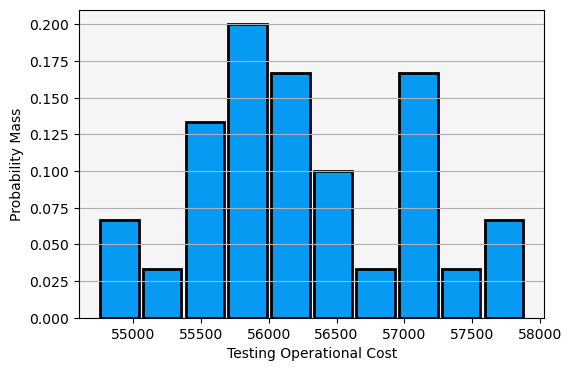

In [51]:
fig, ax = plt.subplots(figsize = (6, 4))

hist, bins = np.histogram(total_costs.sum(axis = 0))

kw = {
    # 'fc': 'lightgray',
    'fc': 'xkcd:azure',
    'ec': 'k',
    'width': (bins[1] - bins[0]) * .9,
    'lw': 2,
}

ax.bar((bins[:-1] + bins[1:]) / 2, hist / sum(hist), **kw)

ax.set(**{
    'xlabel': 'Testing Operational Cost',
    'ylabel': 'Probability Mass',
    'facecolor': 'whitesmoke',
})

ax.grid(axis = 'y')

fig.savefig(fig_path + 'ioniq_50_hist.png', bbox_inches = 'tight', dpi = 300)

In [52]:
routes = json.load(open('Outputs/routes_ioniq_75.json', 'rb'))

In [53]:
nodes_visited = np.concatenate([r['nodes'] for r in routes])
plot_sg = src.graph.subgraph(graph, nodes_visited)

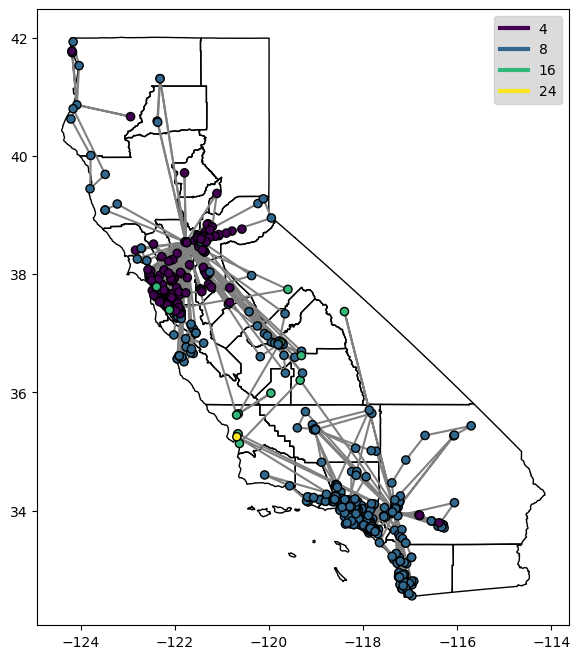

In [54]:
routes = np.random.choice(routes, len(routes), replace = False)

for route in routes:

    route_expected_time = np.array(route['time']).mean()
    
    if route_expected_time <= 4*3600:
        vn = .0

    elif route_expected_time <= 8*3600:
        vn = .33

    elif route_expected_time <= 16*3600:
        vn = .66

    elif route_expected_time <= 24*3600:
        vn = .99
        
    # print(route['vehicle'], vn)
    for n in route['nodes']:
        plot_sg._node[n]['route_vehicle'] = vn

kwargs = {
    'show_links': False,
    'node_field': 'route_vehicle',
    'scatter': {
        's': 35,
        'ec': 'k',
    },
    'line': {
        'color': 'gray',
        'zorder': 0,
    },
}

fig, ax = plt.subplots(figsize = (8, 8))

gdf_zones_california.plot(ax = ax, fc = 'none', ec = 'k', zorder = 0)


src.figures.plot_graph(plot_sg, ax = ax, **kwargs)
src.figures.plot_routes(plot_sg, routes, ax = ax, **kwargs)

from matplotlib.lines import Line2D

colors = src.figures.colormap('viridis')(np.array([0, .33, .66, .99]))
lines = [Line2D([0], [0], color=c, linewidth=3, linestyle='-') for c in colors]
labels = ['4', '8', '16', '24']
ax.legend(lines, labels, facecolor = 'lightgray', markerscale = 40)

fig.savefig(fig_path + 'ioniq_75_map.png', bbox_inches = 'tight', dpi = 300)

In [55]:
times = []
time_costs = []
energy_costs = []
total_costs = []

for route in routes:
    
    times.append(route['time'])
    time_costs.append(np.array(route['time']) *
                      hour_costs[route['nodes'][0]][route['type']]/ 3600)
    energy_costs.append(route['price'])
    total_costs.append(time_costs[-1] + energy_costs[-1])

times = np.array(times) / 3600
time_costs = np.array(time_costs)
energy_costs = np.array(energy_costs)
total_costs = np.array(total_costs)

In [56]:
total_cost['Ioniq'][75] = total_costs.sum(axis = 0)

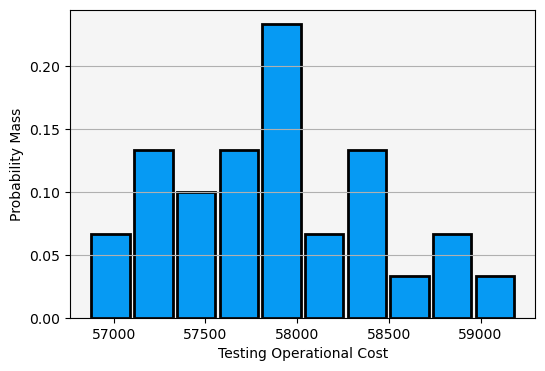

In [57]:
fig, ax = plt.subplots(figsize = (6, 4))

hist, bins = np.histogram(total_costs.sum(axis = 0))

kw = {
    # 'fc': 'lightgray',
    'fc': 'xkcd:azure',
    'ec': 'k',
    'width': (bins[1] - bins[0]) * .9,
    'lw': 2,
}

ax.bar((bins[:-1] + bins[1:]) / 2, hist / sum(hist), **kw)

ax.set(**{
    'xlabel': 'Testing Operational Cost',
    'ylabel': 'Probability Mass',
    'facecolor': 'whitesmoke',
})

ax.grid(axis = 'y')

fig.savefig(fig_path + 'ioniq_75_hist.png', bbox_inches = 'tight', dpi = 300)

In [58]:
routes = json.load(open('Outputs/routes_ioniq_99.json', 'rb'))

In [59]:
nodes_visited = np.concatenate([r['nodes'] for r in routes])
plot_sg = src.graph.subgraph(graph, nodes_visited)

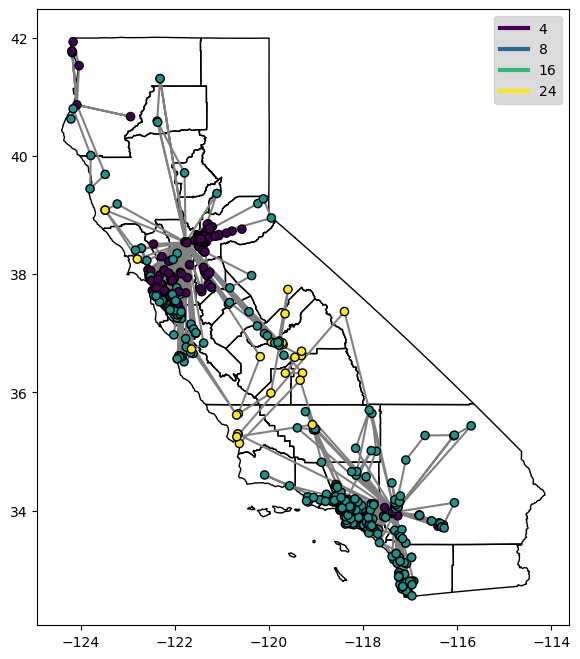

In [60]:
routes = np.random.choice(routes, len(routes), replace = False)

for route in routes:

    route_expected_time = np.array(route['time']).mean()
    
    if route_expected_time <= 4*3600:
        vn = .0

    elif route_expected_time <= 8*3600:
        vn = .33

    elif route_expected_time <= 16*3600:
        vn = .66

    elif route_expected_time <= 24*3600:
        vn = .99
        
    # print(route['vehicle'], vn)
    for n in route['nodes']:
        plot_sg._node[n]['route_vehicle'] = vn

kwargs = {
    'show_links': False,
    'node_field': 'route_vehicle',
    'scatter': {
        's': 35,
        'ec': 'k',
    },
    'line': {
        'color': 'gray',
        'zorder': 0,
    },
}

fig, ax = plt.subplots(figsize = (8, 8))

gdf_zones_california.plot(ax = ax, fc = 'none', ec = 'k', zorder = 0)


src.figures.plot_graph(plot_sg, ax = ax, **kwargs)
src.figures.plot_routes(plot_sg, routes, ax = ax, **kwargs)

from matplotlib.lines import Line2D

colors = src.figures.colormap('viridis')(np.array([0, .33, .66, .99]))
lines = [Line2D([0], [0], color=c, linewidth=3, linestyle='-') for c in colors]
labels = ['4', '8', '16', '24']
ax.legend(lines, labels, facecolor = 'lightgray', markerscale = 40)

fig.savefig(fig_path + 'ioniq_99_map.png', bbox_inches = 'tight', dpi = 300)

In [61]:
times = []
time_costs = []
energy_costs = []
total_costs = []

for route in routes:
    
    times.append(route['time'])
    time_costs.append(np.array(route['time']) *
                      hour_costs[route['nodes'][0]][route['type']]/ 3600)
    energy_costs.append(route['price'])
    total_costs.append(time_costs[-1] + energy_costs[-1])

times = np.array(times) / 3600
time_costs = np.array(time_costs)
energy_costs = np.array(energy_costs)
total_costs = np.array(total_costs)

In [62]:
total_cost['Ioniq'][99] = total_costs.sum(axis = 0)

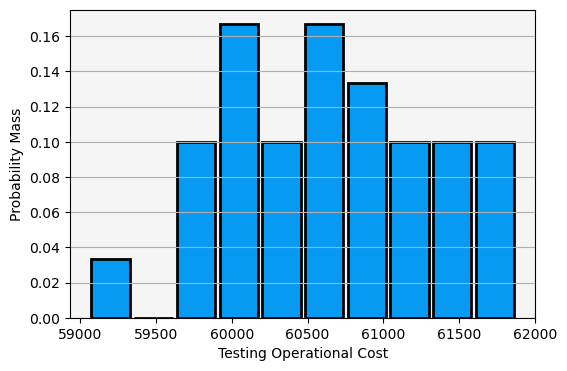

In [63]:
fig, ax = plt.subplots(figsize = (6, 4))

hist, bins = np.histogram(total_costs.sum(axis = 0))

kw = {
    # 'fc': 'lightgray',
    'fc': 'xkcd:azure',
    'ec': 'k',
    'width': (bins[1] - bins[0]) * .9,
    'lw': 2,
}

ax.bar((bins[:-1] + bins[1:]) / 2, hist / sum(hist), **kw)

ax.set(**{
    'xlabel': 'Testing Operational Cost',
    'ylabel': 'Probability Mass',
    'facecolor': 'whitesmoke',
})

ax.grid(axis = 'y')

fig.savefig(fig_path + 'ioniq_99_hist.png', bbox_inches = 'tight', dpi = 300)

In [64]:
routes = json.load(open('Outputs/routes_model_3_50.json', 'rb'))

In [65]:
nodes_visited = np.concatenate([r['nodes'] for r in routes])
plot_sg = src.graph.subgraph(graph, nodes_visited)

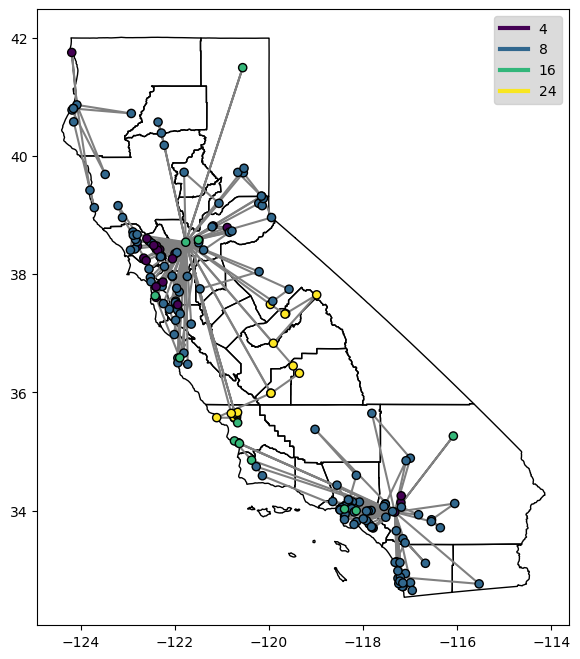

In [66]:
routes = np.random.choice(routes, len(routes), replace = False)

for route in routes:

    route_expected_time = np.array(route['time']).mean()
    
    if route_expected_time <= 4*3600:
        vn = .0

    elif route_expected_time <= 8*3600:
        vn = .33

    elif route_expected_time <= 16*3600:
        vn = .66

    elif route_expected_time <= 24*3600:
        vn = .99
        
    # print(route['vehicle'], vn)
    for n in route['nodes']:
        plot_sg._node[n]['route_vehicle'] = vn

kwargs = {
    'show_links': False,
    'node_field': 'route_vehicle',
    'scatter': {
        's': 35,
        'ec': 'k',
    },
    'line': {
        'color': 'gray',
        'zorder': 0,
    },
}

fig, ax = plt.subplots(figsize = (8, 8))

gdf_zones_california.plot(ax = ax, fc = 'none', ec = 'k', zorder = 0)


src.figures.plot_graph(plot_sg, ax = ax, **kwargs)
src.figures.plot_routes(plot_sg, routes, ax = ax, **kwargs)

from matplotlib.lines import Line2D

colors = src.figures.colormap('viridis')(np.array([0, .33, .66, .99]))
lines = [Line2D([0], [0], color=c, linewidth=3, linestyle='-') for c in colors]
labels = ['4', '8', '16', '24']
ax.legend(lines, labels, facecolor = 'lightgray', markerscale = 40)

fig.savefig(fig_path + 'model_3_50_map.png', bbox_inches = 'tight', dpi = 300)

In [67]:
times = []
time_costs = []
energy_costs = []
total_costs = []

for route in routes:
    
    times.append(route['time'])
    time_costs.append(np.array(route['time']) *
                      hour_costs[route['nodes'][0]][route['type']]/ 3600)
    energy_costs.append(route['price'])
    total_costs.append(time_costs[-1] + energy_costs[-1])

times = np.array(times) / 3600
time_costs = np.array(time_costs)
energy_costs = np.array(energy_costs)
total_costs = np.array(total_costs)

In [68]:
total_cost['Model 3'][50] = total_costs.sum(axis = 0)

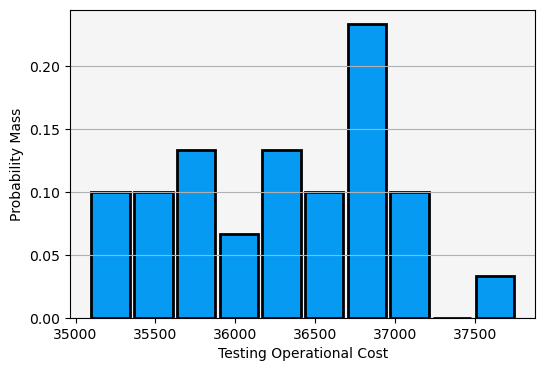

In [69]:
fig, ax = plt.subplots(figsize = (6, 4))

hist, bins = np.histogram(total_costs.sum(axis = 0))

kw = {
    # 'fc': 'lightgray',
    'fc': 'xkcd:azure',
    'ec': 'k',
    'width': (bins[1] - bins[0]) * .9,
    'lw': 2,
}

ax.bar((bins[:-1] + bins[1:]) / 2, hist / sum(hist), **kw)

ax.set(**{
    'xlabel': 'Testing Operational Cost',
    'ylabel': 'Probability Mass',
    'facecolor': 'whitesmoke',
})

ax.grid(axis = 'y')

fig.savefig(fig_path + 'model_3_50_hist.png', bbox_inches = 'tight', dpi = 300)

In [95]:
routes = json.load(open('Outputs/routes_model_3_75.json', 'rb'))

In [96]:
nodes_visited = np.concatenate([r['nodes'] for r in routes])
plot_sg = src.graph.subgraph(graph, nodes_visited)

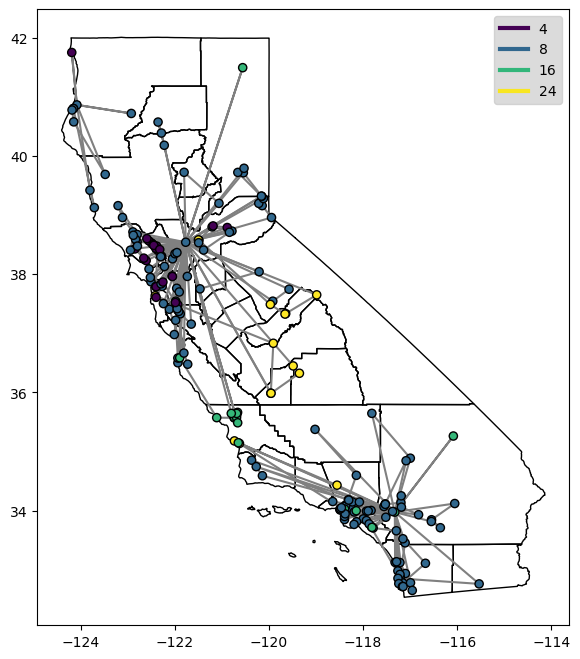

In [97]:
routes = np.random.choice(routes, len(routes), replace = False)

for route in routes:

    route_expected_time = np.array(route['time']).mean()
    
    if route_expected_time <= 4*3600:
        vn = .0

    elif route_expected_time <= 8*3600:
        vn = .33

    elif route_expected_time <= 16*3600:
        vn = .66

    elif route_expected_time <= 24*3600:
        vn = .99
        
    # print(route['vehicle'], vn)
    for n in route['nodes']:
        plot_sg._node[n]['route_vehicle'] = vn

kwargs = {
    'show_links': False,
    'node_field': 'route_vehicle',
    'scatter': {
        's': 35,
        'ec': 'k',
    },
    'line': {
        'color': 'gray',
        'zorder': 0,
    },
}

fig, ax = plt.subplots(figsize = (8, 8))

gdf_zones_california.plot(ax = ax, fc = 'none', ec = 'k', zorder = 0)


src.figures.plot_graph(plot_sg, ax = ax, **kwargs)
src.figures.plot_routes(plot_sg, routes, ax = ax, **kwargs)

from matplotlib.lines import Line2D

colors = src.figures.colormap('viridis')(np.array([0, .33, .66, .99]))
lines = [Line2D([0], [0], color=c, linewidth=3, linestyle='-') for c in colors]
labels = ['4', '8', '16', '24']
ax.legend(lines, labels, facecolor = 'lightgray', markerscale = 40)

fig.savefig(fig_path + 'model_3_75_map.png', bbox_inches = 'tight', dpi = 300)

In [73]:
times = []
time_costs = []
energy_costs = []
total_costs = []

for route in routes:
    
    times.append(route['time'])
    time_costs.append(np.array(route['time']) *
                      hour_costs[route['nodes'][0]][route['type']]/ 3600)
    energy_costs.append(route['price'])
    total_costs.append(time_costs[-1] + energy_costs[-1])

times = np.array(times) / 3600
time_costs = np.array(time_costs)
energy_costs = np.array(energy_costs)
total_costs = np.array(total_costs)

In [74]:
total_cost['Model 3'][75] = total_costs.sum(axis = 0)

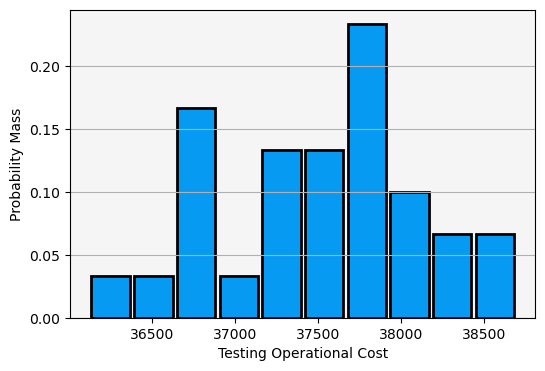

In [75]:
fig, ax = plt.subplots(figsize = (6, 4))

hist, bins = np.histogram(total_costs.sum(axis = 0))

kw = {
    # 'fc': 'lightgray',
    'fc': 'xkcd:azure',
    'ec': 'k',
    'width': (bins[1] - bins[0]) * .9,
    'lw': 2,
}

ax.bar((bins[:-1] + bins[1:]) / 2, hist / sum(hist), **kw)

ax.set(**{
    'xlabel': 'Testing Operational Cost',
    'ylabel': 'Probability Mass',
    'facecolor': 'whitesmoke',
})

ax.grid(axis = 'y')

fig.savefig(fig_path + 'model_3_75_hist.png', bbox_inches = 'tight', dpi = 300)

In [92]:
routes = json.load(open('Outputs/routes_model_3_99.json', 'rb'))

In [93]:
nodes_visited = np.concatenate([r['nodes'] for r in routes])
plot_sg = src.graph.subgraph(graph, nodes_visited)

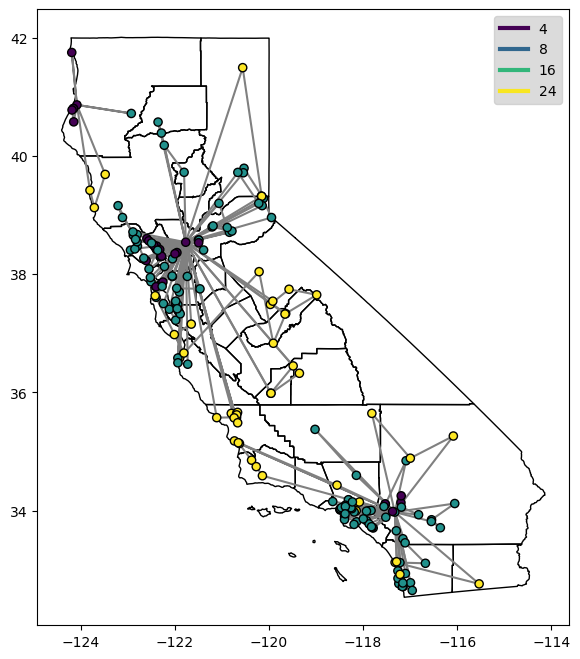

In [94]:
routes = np.random.choice(routes, len(routes), replace = False)

for route in routes:

    route_expected_time = np.array(route['time']).mean()
    
    if route_expected_time <= 4*3600:
        vn = .0

    elif route_expected_time <= 8*3600:
        vn = .33

    elif route_expected_time <= 16*3600:
        vn = .66

    elif route_expected_time <= 24*3600:
        vn = .99
        
    # print(route['vehicle'], vn)
    for n in route['nodes']:
        plot_sg._node[n]['route_vehicle'] = vn

kwargs = {
    'show_links': False,
    'node_field': 'route_vehicle',
    'scatter': {
        's': 35,
        'ec': 'k',
    },
    'line': {
        'color': 'gray',
        'zorder': 0,
    },
}

fig, ax = plt.subplots(figsize = (8, 8))

gdf_zones_california.plot(ax = ax, fc = 'none', ec = 'k', zorder = 0)


src.figures.plot_graph(plot_sg, ax = ax, **kwargs)
src.figures.plot_routes(plot_sg, routes, ax = ax, **kwargs)

from matplotlib.lines import Line2D

colors = src.figures.colormap('viridis')(np.array([0, .33, .66, .99]))
lines = [Line2D([0], [0], color=c, linewidth=3, linestyle='-') for c in colors]
labels = ['4', '8', '16', '24']
ax.legend(lines, labels, facecolor = 'lightgray', markerscale = 40)

fig.savefig(fig_path + 'model_3_99_map.png', bbox_inches = 'tight', dpi = 300)

In [79]:
times = []
time_costs = []
energy_costs = []
total_costs = []

for route in routes:
    
    times.append(route['time'])
    time_costs.append(np.array(route['time']) *
                      hour_costs[route['nodes'][0]][route['type']]/ 3600)
    energy_costs.append(route['price'])
    total_costs.append(time_costs[-1] + energy_costs[-1])

times = np.array(times) / 3600
time_costs = np.array(time_costs)
energy_costs = np.array(energy_costs)
total_costs = np.array(total_costs)

In [80]:
total_cost['Model 3'][99] = total_costs.sum(axis = 0)

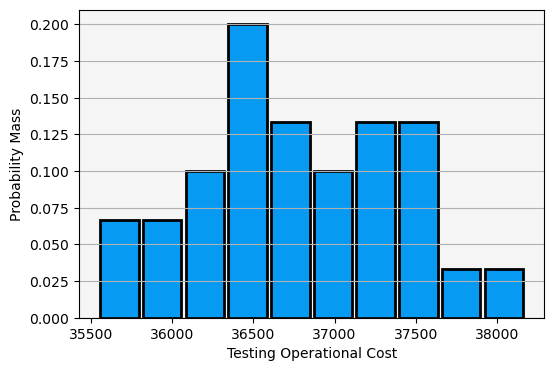

In [81]:
fig, ax = plt.subplots(figsize = (6, 4))

hist, bins = np.histogram(total_costs.sum(axis = 0))

kw = {
    # 'fc': 'lightgray',
    'fc': 'xkcd:azure',
    'ec': 'k',
    'width': (bins[1] - bins[0]) * .9,
    'lw': 2,
}

ax.bar((bins[:-1] + bins[1:]) / 2, hist / sum(hist), **kw)

ax.set(**{
    'xlabel': 'Testing Operational Cost',
    'ylabel': 'Probability Mass',
    'facecolor': 'whitesmoke',
})

ax.grid(axis = 'y')

fig.savefig(fig_path + 'model_3_99_hist.png', bbox_inches = 'tight', dpi = 300)

In [111]:
scenario = 50

project_operational_cost = np.zeros((30, ))

for value in total_cost.values():

    project_operational_cost += value[scenario]

round(project_operational_cost.mean()), round(project_operational_cost.std())

(199291, 1594)

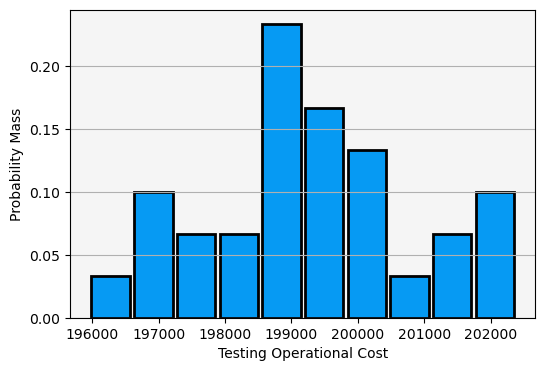

In [83]:
fig, ax = plt.subplots(figsize = (6, 4))

hist, bins = np.histogram(project_operational_cost)

kw = {
    # 'fc': 'lightgray',
    'fc': 'xkcd:azure',
    'ec': 'k',
    'width': (bins[1] - bins[0]) * .9,
    'lw': 2,
}

ax.bar((bins[:-1] + bins[1:]) / 2, hist / sum(hist), **kw)

ax.set(**{
    'xlabel': 'Testing Operational Cost',
    'ylabel': 'Probability Mass',
    'facecolor': 'whitesmoke',
})

ax.grid(axis = 'y')

fig.savefig(fig_path + 'project_50_hist.png', bbox_inches = 'tight', dpi = 300)

In [112]:
scenario = 75

project_operational_cost = np.zeros((30, ))

for value in total_cost.values():

    project_operational_cost += value[scenario]

round(project_operational_cost.mean()), round(project_operational_cost.std())

(203843, 1253)

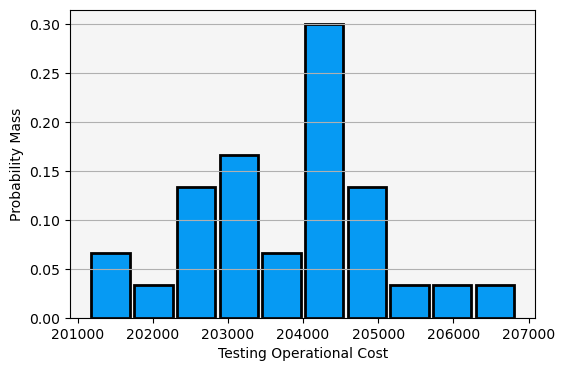

In [85]:
fig, ax = plt.subplots(figsize = (6, 4))

hist, bins = np.histogram(project_operational_cost)

kw = {
    # 'fc': 'lightgray',
    'fc': 'xkcd:azure',
    'ec': 'k',
    'width': (bins[1] - bins[0]) * .9,
    'lw': 2,
}

ax.bar((bins[:-1] + bins[1:]) / 2, hist / sum(hist), **kw)

ax.set(**{
    'xlabel': 'Testing Operational Cost',
    'ylabel': 'Probability Mass',
    'facecolor': 'whitesmoke',
})

ax.grid(axis = 'y')

fig.savefig(fig_path + 'project_75_hist.png', bbox_inches = 'tight', dpi = 300)

In [113]:
scenario = 99

project_operational_cost = np.zeros((30, ))

for value in total_cost.values():

    project_operational_cost += value[scenario]

round(project_operational_cost.mean()), round(project_operational_cost.std())

(209145, 1308)

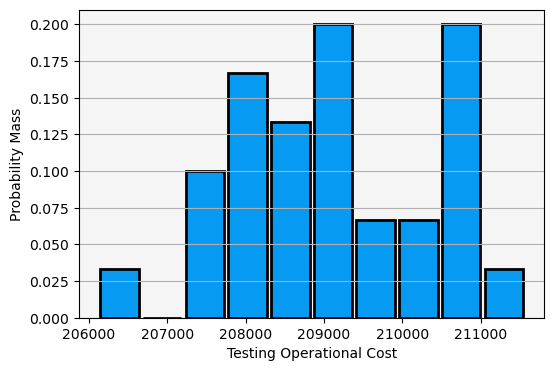

In [87]:
fig, ax = plt.subplots(figsize = (6, 4))

hist, bins = np.histogram(project_operational_cost)

kw = {
    # 'fc': 'lightgray',
    'fc': 'xkcd:azure',
    'ec': 'k',
    'width': (bins[1] - bins[0]) * .9,
    'lw': 2,
}

ax.bar((bins[:-1] + bins[1:]) / 2, hist / sum(hist), **kw)

ax.set(**{
    'xlabel': 'Testing Operational Cost',
    'ylabel': 'Probability Mass',
    'facecolor': 'whitesmoke',
})

ax.grid(axis = 'y')

fig.savefig(fig_path + 'project_99_hist.png', bbox_inches = 'tight', dpi = 300)

In [88]:
graph.number_of_nodes()

2003

In [100]:
sum([min([2, np.nanmax([0, n['n_ac']])]) for n in graph._node.values()])

2765.0

In [102]:
sum([min([4, np.nanmax([0, n['n_dc']])]) for n in graph._node.values()])

1200.0

In [108]:
vehs = ['Bolt', 'Lightning', 'Ioniq', 'Model 3']
scenarios = [50, 75, 99]

output = np.zeros((3, 3))

for idx1, scenario in enumerate(scenarios):
    for idx0, veh in enumerate(vehs):
        
        mu = value.mean()
        sigma = value.mean()

        output[idx1] += np.array(
            [round(mu), round(mu + .67 * sigma), round(mu + 2.33 * sigma)]
        )

        # print(round(mu), round(mu + .67 * sigma), round(mu + 2.33 * sigma))
print(output)

[[147124. 245696. 489920.]
 [147124. 245696. 489920.]
 [147124. 245696. 489920.]]


In [91]:
total_cost

{'Bolt': {50: array([51695.48521064, 52267.91237015, 53612.14571959, 52345.6861594 ,
         52375.36831874, 51718.321423  , 53462.76831922, 51130.27318358,
         53081.83274735, 53276.32446931, 52436.18892572, 53726.10329401,
         52346.45816373, 54192.38793004, 52546.20287501, 51157.37135129,
         51551.45958951, 53590.72253405, 52336.83911768, 52735.39674021,
         52144.21864361, 54561.66482101, 52341.40196546, 53143.8810678 ,
         53092.05933177, 53785.89354338, 54168.31395406, 51878.60977682,
         52476.35003659, 52557.01565074]),
  75: array([55367.24658359, 55301.47816136, 53695.25862826, 55169.69864249,
         54192.75754857, 54638.07641507, 55729.31150131, 55559.19436133,
         55589.94992433, 55443.58315873, 55256.87656228, 55114.94257138,
         55661.0677886 , 53396.31505449, 56335.10153043, 54212.70399496,
         54604.67229495, 54180.06031926, 54075.57431719, 55428.42324067,
         52997.00018457, 54432.79694001, 55021.79668149, 55932.80

In [137]:
np.random.triangular(1, 3, 5)

3.419465963378466